In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import config as config
import data_loader as dl
import features.taxi_config as tc
import features.taxi_features as tf


# Load taxi dataset

In [2]:
taxi_data_raw = dl.load_taxi_data()

# Univariat EDA Taxidata

## EDA general

In [3]:
taxi_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- 1458644 rows
- 11 columns
- object: id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
- int64: vendor_id, passenger_count, trip_duration
- float64: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
- no missing values/categories

- no NaNs

- id can be used for unique ID
- two unique vendors seems to be all right
- ten unique passengers
- two unique store_and_fwd_flag matches with description

- no duplicated rows

## EDA vendor_id

In [4]:
# Vendor ID
taxi_data_raw['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

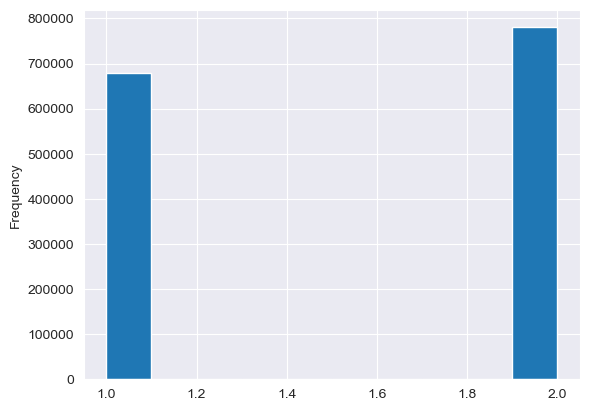

In [5]:
taxi_data_raw['vendor_id'].plot.hist()

- Only two unique values: 1 and 2.
- Frequencies are relatively balanced.
- No missing values or anomalies detected.

## EDA pickup_datetime & dropoff_datetime

In [6]:
taxi_data_raw['pickup_datetime'].describe()

count                 1458644
unique                1380222
top       2016-03-04 08:07:34
freq                        5
Name: pickup_datetime, dtype: object

In [7]:
taxi_data_raw['dropoff_datetime'].describe()

count                 1458644
unique                1380377
top       2016-02-19 19:25:04
freq                        5
Name: dropoff_datetime, dtype: object

In [8]:
# noinspection PyUnresolvedReferences
(taxi_data_raw['dropoff_datetime'] < taxi_data_raw['pickup_datetime']).sum()

np.int64(0)

- no negative durations

In [9]:
# Basic datetime features
taxi_data = tf.add_taxi_time_features(taxi_data_raw)

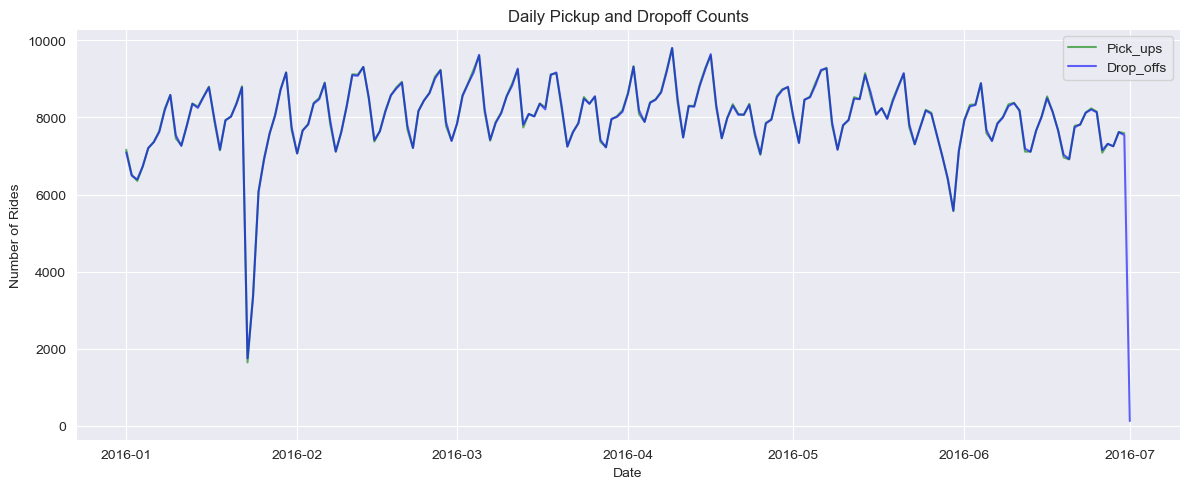

In [10]:
pickup_counts = taxi_data['pickup_datetime'].dt.date.value_counts().sort_index()
dropoff_counts = taxi_data['dropoff_datetime'].dt.date.value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
pickup_counts.plot(ax=ax, label="Pick_ups", color='green', alpha=0.6)
dropoff_counts.plot(ax=ax, label="Drop_offs", color='blue', alpha=0.6)

ax.set_title("Daily Pickup and Dropoff Counts")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='pickup_hour'>

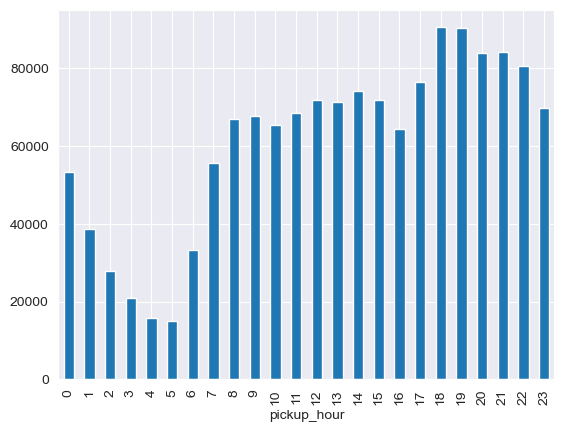

In [11]:
taxi_data["pickup_hour"].value_counts().sort_index().plot(kind='bar')

- peak from 18 to 22
- trough from 1 to 6

<Axes: xlabel='pickup_weekday'>

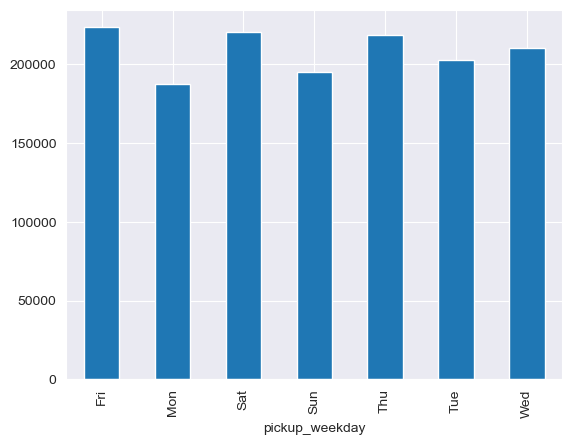

In [12]:
taxi_data['pickup_weekday'].value_counts().sort_index().plot(kind='bar')

In [13]:
taxi_data['pickup_weekday'].value_counts().sort_index()

pickup_weekday
Fri    223533
Mon    187418
Sat    220868
Sun    195366
Thu    218574
Tue    202749
Wed    210136
Name: count, dtype: int64

- trough on Sunday
- peak on Friday

<Axes: xlabel='pickup_month'>

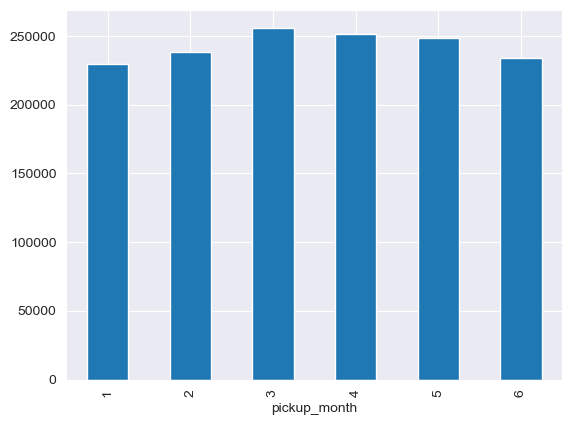

In [14]:
taxi_data['pickup_month'].value_counts().sort_index().plot(kind='bar')

In [15]:
taxi_data['pickup_month'].value_counts().sort_index()

pickup_month
1    229707
2    238300
3    256189
4    251645
5    248487
6    234316
Name: count, dtype: int64

- trough in January
- peak in March

In [16]:
taxi_data.groupby(['pickup_datetime']).size().sort_values(ascending=False).head()

pickup_datetime
2016-03-04 08:07:34    5
2016-01-12 18:48:44    5
2016-06-10 23:17:17    5
2016-02-09 21:03:38    5
2016-05-07 13:18:07    5
dtype: int64

- could be repeated records

<Axes: xlabel='pickup_hour'>

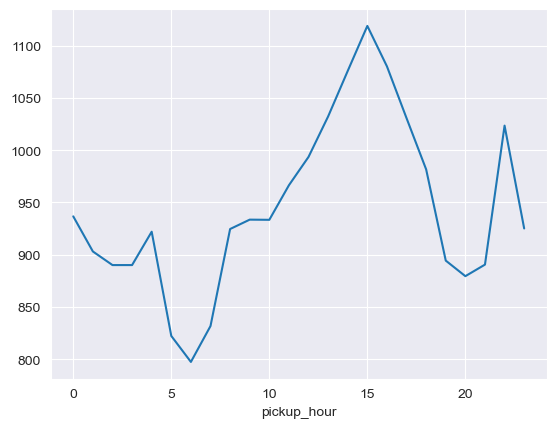

In [17]:
taxi_data.groupby('pickup_hour')['trip_duration'].mean().plot()

- aligns with expected rush hour effects

## EDA passenger_count

Findings
- The majority of trips have 1 passenger; distribution is heavily right-skewed
- Edge values observed: 60 trips with 0 passengers, and very few with 7–9 passengers
- These edge values are likely invalid or extremely rare
- Trips with 0 passengers show the highest average trip duration, which is implausible and suggests data entry or system error
- Passenger counts 7–9 are extremely rare and may suffer from sampling bias or logging issues
- These edge cases collectively make up a very small share of the data (<0.01%)

In [18]:
taxi_data["passenger_count"].describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

In [19]:
# Passenger count
taxi_data['passenger_count'].value_counts().sort_index()

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: count, dtype: int64

- 60 with passenger count 0
- 5 with passenger count > 6

<Axes: xlabel='passenger_count'>

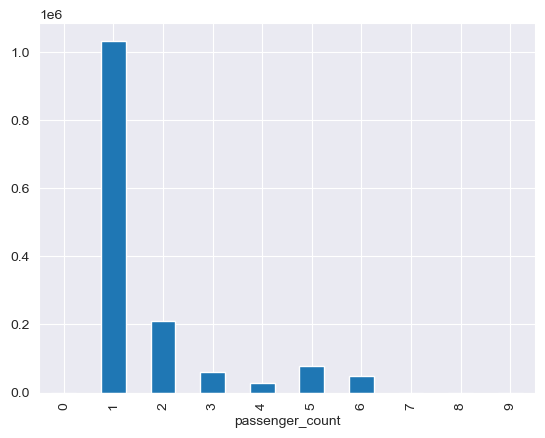

In [20]:
taxi_data['passenger_count'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='passenger_count'>

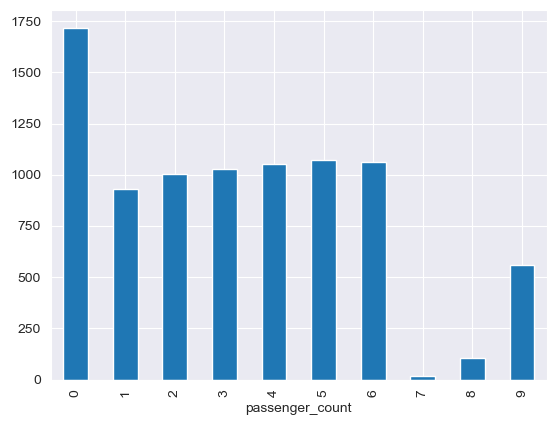

In [21]:
taxi_data.groupby('passenger_count')['trip_duration'].mean().plot(kind='bar')

- Passenger count = 0 has the highest average trip duration, which is not plausible, indicating likely data entry or logging errors

<Axes: xlabel='pickup_hour'>

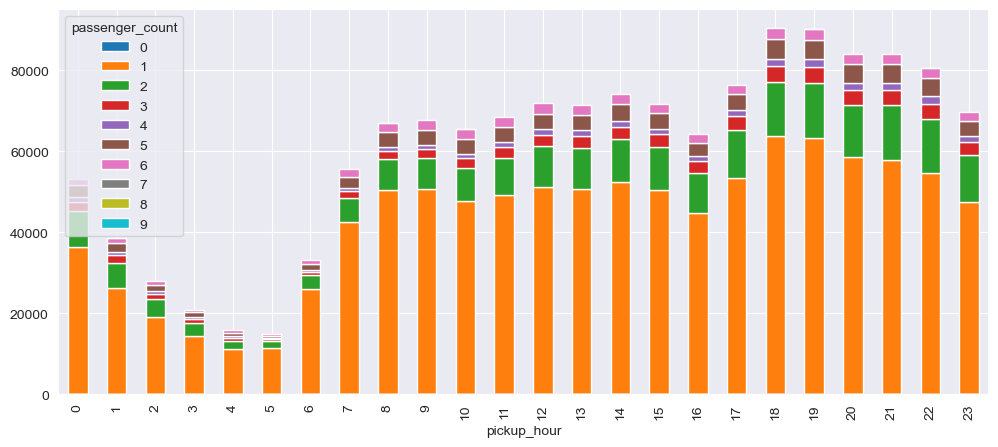

In [22]:
pd.crosstab(taxi_data['pickup_hour'], taxi_data['passenger_count']).plot(
    kind='bar', stacked=True, figsize=(12, 5)
)

- Passenger count = 1 dominates at all hours
- Group trips (2–4 passengers) are more frequent in the evening and late night

In [23]:
edge_cases = taxi_data['passenger_count'].isin([0, 7, 8, 9])
edge_cases.mean()

np.float64(4.4561935605946344e-05)

- 0.0045% of trips are likely outliers or errors

## Explore pickup_longitude, pickup_latitude & dropoff_longitude, dropoff_latitude

In [24]:
# Summary statistics for coordinates
taxi_data[
  ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,4.075092e+01,-7.397349e+01,4.075180e+01,-7.397342e+01
std,3.288119e-02,7.090186e-02,3.589056e-02,7.064327e-02
min,3.435970e+01,-1.219333e+02,3.218114e+01,-1.219333e+02
25%,4.073735e+01,-7.399187e+01,4.073588e+01,-7.399133e+01
50%,4.075410e+01,-7.398174e+01,4.075452e+01,-7.397975e+01
75%,4.076836e+01,-7.396733e+01,4.076981e+01,-7.396301e+01
max,5.188108e+01,-6.133553e+01,4.392103e+01,-6.133553e+01


In [25]:
taxi_data[
  (taxi_data['pickup_latitude'] < tc.NYC_LAT_MIN) | (
      taxi_data['pickup_latitude'] > tc.NYC_LAT_MAX) |
  (taxi_data['dropoff_latitude'] < tc.NYC_LAT_MIN) | (
      taxi_data['dropoff_latitude'] > tc.NYC_LAT_MAX) |
  (taxi_data['pickup_longitude'] < tc.NYC_LON_MIN) | (
      taxi_data['pickup_longitude'] > tc.NYC_LON_MAX) |
  (taxi_data['dropoff_longitude'] < tc.NYC_LON_MIN) | (
      taxi_data['dropoff_longitude'] > tc.NYC_LON_MAX)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_weekday,pickup_month,hour_of_year
115,id2358953,2,2016-06-27 00:31:28,2016-06-27 01:06:44,1,-73.870819,40.773739,-73.857498,41.017811,N,2116,0,Mon,6,4272
991,id1859156,1,2016-02-17 00:54:13,2016-02-17 01:36:27,3,-73.969254,40.754047,-73.593582,41.043865,N,2534,0,Wed,2,1128
1101,id3913560,2,2016-01-11 22:48:55,2016-01-11 23:40:20,2,-74.012657,40.702179,-74.307762,40.567341,N,3085,22,Mon,1,262
9565,id0304778,1,2016-02-23 20:38:44,2016-02-23 21:19:17,1,-73.982925,40.761841,-74.379631,40.745274,N,2433,20,Tue,2,1292
13006,id3022813,1,2016-06-15 18:02:41,2016-06-15 18:03:18,1,-73.558289,40.781223,-73.558281,40.781227,N,37,18,Wed,6,4002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449228,id2148312,2,2016-04-23 22:44:36,2016-04-23 23:31:57,1,-73.790451,40.646904,-73.837021,41.061226,N,2841,22,Sat,4,2734
1449384,id3101192,1,2016-05-17 20:43:33,2016-05-17 22:13:12,2,-73.979401,40.752388,-73.872871,41.040192,N,5379,20,Tue,5,3308
1450700,id1292498,1,2016-06-23 07:02:07,2016-06-23 08:28:12,1,-73.782013,40.644894,-73.774452,41.031044,N,5165,7,Thu,6,4183
1454301,id1367595,2,2016-04-09 01:38:09,2016-04-09 02:14:52,1,-74.047142,40.789986,-74.010872,41.112366,N,2203,1,Sat,4,2377


- Some trip coordinates lie outside NYC bounds
- Some points lie far outside the visible city bounds — likely due to GPS glitches or data corruption.

In [26]:
(taxi_data['pickup_longitude'] % 0.001 < 1e-10).mean()

np.float64(9.049500769207565e-05)

In [27]:
(taxi_data['pickup_latitude'] % 0.001 < 1e-10).mean()

np.float64(0.0)

In [28]:
(taxi_data['dropoff_latitude'] % 0.001 < 1e-10).mean()

np.float64(0.0)

In [29]:
(taxi_data['dropoff_longitude'] % 0.001 < 1e-10).mean()

np.float64(7.33558016897886e-05)

- no rounding issues

### Geographic distribution

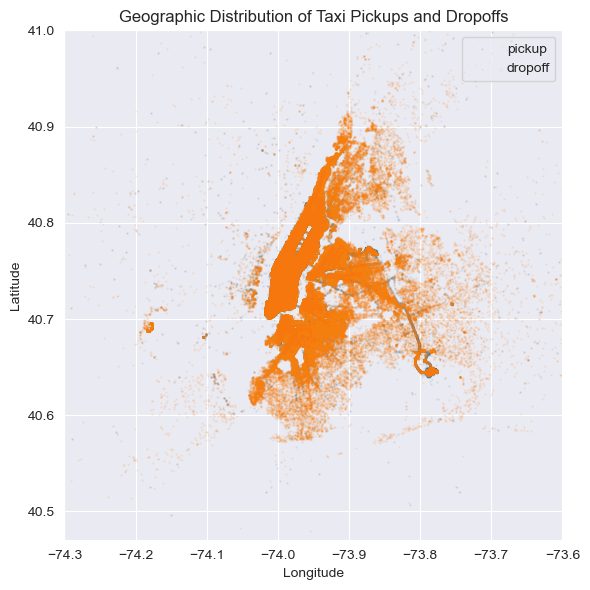

In [30]:
# Scatterplot of pickup and dropoff locations
plt.figure(figsize=(6, 6))
plt.scatter(taxi_data['pickup_longitude'], taxi_data['pickup_latitude'], s=0.5, alpha=0.1,
            label='pickup')
plt.scatter(taxi_data['dropoff_longitude'], taxi_data['dropoff_latitude'], s=0.5, alpha=0.1,
            label='dropoff')
plt.xlim(tc.NYC_LON_MIN, tc.NYC_LON_MAX)
plt.ylim(tc.NYC_LAT_MIN, tc.NYC_LAT_MAX)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')
plt.title("Geographic Distribution of Taxi Pickups and Dropoffs")
plt.grid(True)
plt.tight_layout()
plt.show()

- Most pickups and dropoffs are located within the NYC area (Manhattan, Brooklyn, Queens).
- Clear density clusters appear around Midtown and Downtown Manhattan.

In [31]:
taxi_data[
  (taxi_data['pickup_latitude'].round(5) == taxi_data['dropoff_latitude'].round(5)) &
  (taxi_data['pickup_longitude'].round(5) == taxi_data['dropoff_longitude'].round(5)) &
  (taxi_data['trip_duration'] > 300)  # more than 5 minutes
  ].shape[0]

3195

- implausible values

## Explore store_and_fwd_flag

In [32]:
taxi_data['store_and_fwd_flag'].value_counts(normalize=True)

store_and_fwd_flag
N    0.994485
Y    0.005515
Name: proportion, dtype: float64

<Axes: xlabel='store_and_fwd_flag'>

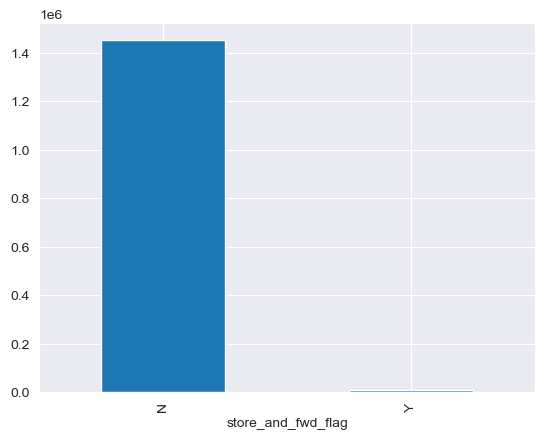

In [33]:
taxi_data['store_and_fwd_flag'].value_counts().sort_index().plot(kind='bar')

- store_and_fwd_flag = 'Y' is rare and likely not predictive on its own

## EDA trip_duration

In [34]:
taxi_data = tf.add_trip_duration_features(taxi_data)

In [35]:
# Summary statistics for trip duration
taxi_data['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [36]:
# Check for extreme trip durations
taxi_data[taxi_data['trip_duration'] > 3 * 3600]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_weekday,pickup_month,hour_of_year,trip_duration_min,trip_duration_log
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594,4,Sat,2,1204,1409.900000,11.345630
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149,18,Sat,5,3066,1435.816667,11.363845
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352,12,Tue,6,3804,1439.200000,11.366199
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236,0,Sat,2,1032,1437.266667,11.364855
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197,11,Fri,3,1859,1419.950000,11.352733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455097,id2798196,2,2016-03-20 03:51:36,2016-03-21 00:00:00,2,-73.969299,40.757301,-73.870277,40.709808,N,72504,3,Sun,3,1899,1208.400000,11.191411
1456458,id2055880,2,2016-02-08 19:11:31,2016-02-09 19:08:44,3,-73.973282,40.760792,-73.988518,40.764210,N,86233,19,Mon,2,931,1437.216667,11.364820
1457207,id1910950,2,2016-06-08 16:29:12,2016-06-09 16:11:03,1,-73.958061,40.800869,-73.964119,40.805515,N,85311,16,Wed,6,3832,1421.850000,11.354070
1457752,id1215198,2,2016-02-02 11:31:10,2016-02-03 11:29:44,6,-73.972069,40.794220,-73.961014,40.806728,N,86314,11,Tue,2,779,1438.566667,11.365759


In [37]:
taxi_data[taxi_data['trip_duration'] < 60]  # < 1 minute

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_weekday,pickup_month,hour_of_year,trip_duration_min,trip_duration_log
72,id1510700,2,2016-02-20 21:58:13,2016-02-20 21:59:10,1,-73.958397,40.772629,-73.955132,40.774242,N,57,21,Sat,2,1221,0.950000,4.060443
323,id2954399,1,2016-06-27 11:22:37,2016-06-27 11:23:17,1,-74.001030,40.756653,-74.000999,40.756626,N,40,11,Mon,6,4283,0.666667,3.713572
842,id3263580,2,2016-05-21 12:46:46,2016-05-21 12:46:49,2,-73.782372,40.648766,-73.782372,40.648746,N,3,12,Sat,5,3396,0.050000,1.386294
853,id2730154,2,2016-03-29 22:39:46,2016-03-29 22:40:44,5,-73.982201,40.731812,-73.979950,40.734814,N,58,22,Tue,3,2134,0.966667,4.077537
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,N,2,13,Thu,6,4189,0.033333,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458044,id3200588,2,2016-03-12 01:35:35,2016-03-12 01:35:42,1,-74.007378,40.739441,-74.007378,40.739449,N,7,1,Sat,3,1705,0.116667,2.079442
1458085,id1326136,2,2016-05-21 12:07:11,2016-05-21 12:07:28,1,-73.978935,40.762463,-73.977654,40.762012,N,17,12,Sat,5,3396,0.283333,2.890372
1458140,id0175875,1,2016-03-22 06:18:10,2016-03-22 06:18:47,1,-73.991325,40.744934,-73.989388,40.748024,N,37,6,Tue,3,1950,0.616667,3.637586
1458544,id3958653,1,2016-06-16 15:10:11,2016-06-16 15:10:49,1,-73.956459,40.767231,-73.956589,40.767269,N,38,15,Thu,6,4023,0.633333,3.663562


- Several trips have a duration longer than 2 hours, which is highly unlikely for intra-city NYC taxi rides. A few trips are also shorter than 1 minute, which may indicate errors or missing data.

<Axes: xlabel='trip_duration'>

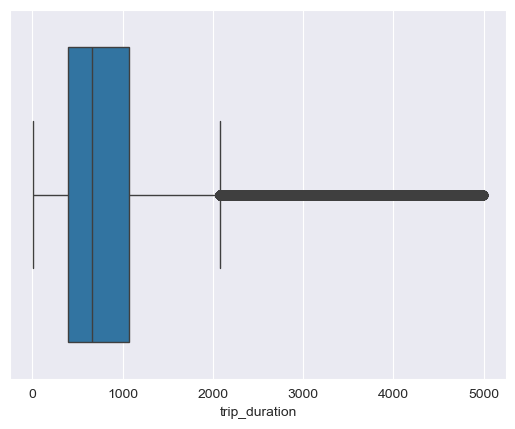

In [38]:
sns.boxplot(x=taxi_data['trip_duration'][taxi_data['trip_duration'] < 5000])

## Distance Features

### Haversine

In [39]:
taxi_data = tf.add_taxi_distance_features(taxi_data)

<Axes: xlabel='hav_dist_km', ylabel='trip_duration_min'>

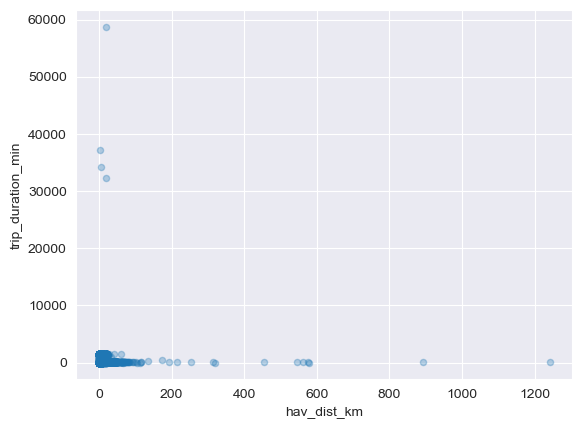

In [40]:
taxi_data.plot.scatter(x='hav_dist_km', y='trip_duration_min', alpha=0.3)

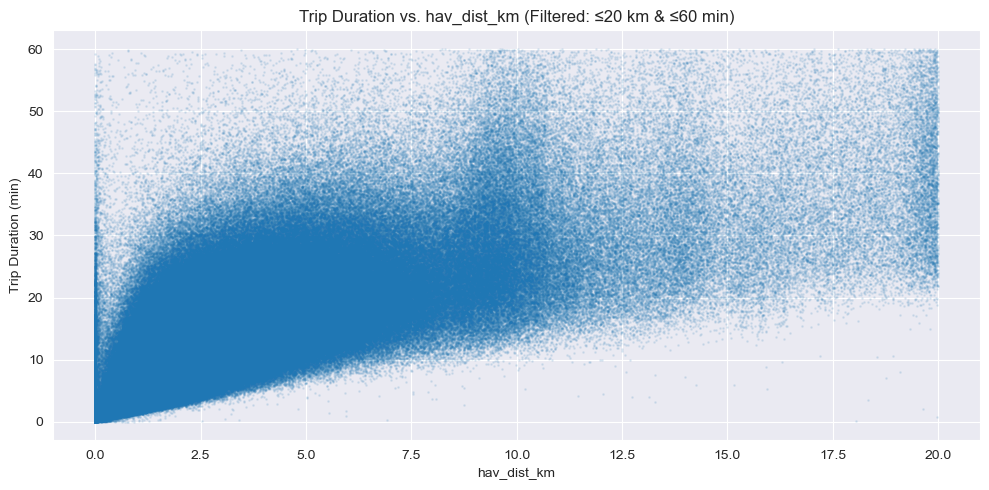

In [41]:
# Filter for clearer visualization
filtered_data = taxi_data[
  (taxi_data['hav_dist_km'] <= 20) &
  (taxi_data['trip_duration_min'] <= 60)
  ]

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(filtered_data['hav_dist_km'], filtered_data['trip_duration_min'], alpha=0.1, s=1)
plt.xlabel("hav_dist_km")
plt.ylabel("Trip Duration (min)")
plt.title("Trip Duration vs. hav_dist_km (Filtered: ≤20 km & ≤60 min)")
plt.grid(True)
plt.tight_layout()
plt.show()

- Long durations at very short distances
- Long distances with short durations

- For trips under ~2 km, durations vary widely
- Some points still lie far above the trend line

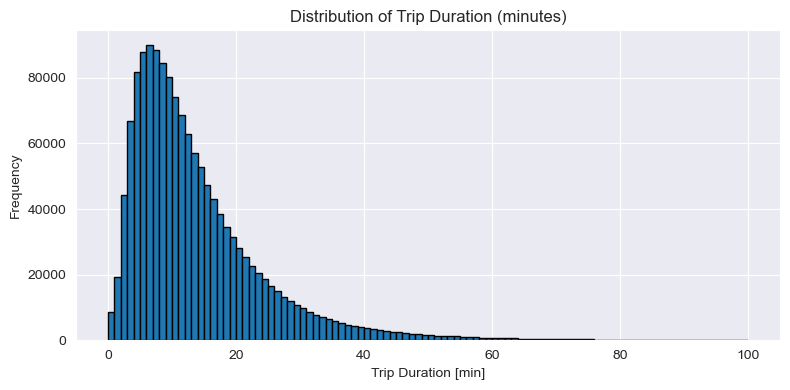

In [42]:
# Histogram (capped at 100 minutes for clarity)
plt.figure(figsize=(8, 4))
plt.hist(taxi_data['trip_duration_min'], bins=100, range=(0, 100), edgecolor='black')
plt.title("Distribution of Trip Duration (minutes)")
plt.xlabel("Trip Duration [min]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

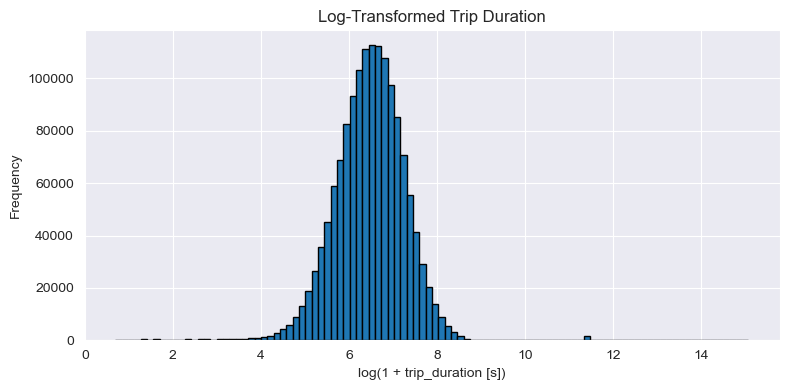

In [43]:
# Log-transformed trip duration
taxi_data['trip_duration_log'] = np.log1p(taxi_data['trip_duration'])

plt.figure(figsize=(8, 4))
plt.hist(taxi_data['trip_duration_log'], bins=100, edgecolor='black')
plt.title("Log-Transformed Trip Duration")
plt.xlabel("log(1 + trip_duration [s])")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

- log1p(trip_duration) helps stabilize variance, handle skewness, and improve model performance

# Save Taxi Data

In [44]:
taxi_data.to_csv(config.TAXI_DATA_SAVE, index=False)

In [45]:
taxi_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_weekday,pickup_month,hour_of_year,trip_duration_min,trip_duration_log,hav_dist_km
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,Mon,3,1769,7.583333,6.122493,1.500199
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,Sun,6,3912,11.050000,6.498282,1.807529
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,Tue,1,443,35.400000,7.661527,6.392249
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,Wed,4,2323,7.150000,6.063785,1.487162
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,Sat,3,2053,7.250000,6.077642,1.189920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,13,Fri,4,2365,12.966667,6.658011,1.226452
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,7,Sun,1,223,10.916667,6.486161,6.056611
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,6,Fri,4,2694,12.733333,6.639876,7.833369
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,15,Tue,1,111,6.216667,5.924256,1.093787
